In [5]:
!pip install pandas_datareader

In [38]:
import numpy as np
import math
import datetime
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.stats as stats
import time
from mpl_toolkits import mplot3d


# Pricing d'une option européenne vanille : Méthode analytique par Black-Scholes

In [25]:
#Initialisation des paramètres de la formule de Black Scholes :

S = 100.0  # Option price
K = 100.0  # Strike price
r = 0.05   # Risk-free rate (5%)
sigma = 0.2    # Volatility of the underlying (20%) cette valeur est la plus difficile à évaluer en pratique
T = 1.0

In [26]:
def density_gaussian(x) :
    return norm.pdf(x,0,1)

def repartition_gaussian(y) :
    return norm.cdf(y)

In [27]:
repartition_gaussian(10)

1.0

In [28]:
#D'après la formule de Black-Scholes, il nous faut calculer d'abord les d1/d2

def d1(S,K,r,sigma,T) :
    if sigma*T**(1/2) == 0:
        return np.nan
    else:
        return (np.log(S/K)+(r+(sigma**2)/2)*T)/sigma*T**(1/2)

def d2(sigma,T) :
    return d1(S,K,r,sigma,T)-sigma*T**(1/2)


In [29]:
d1(S,K,r,sigma,T)

0.35000000000000003

In [30]:
d2(sigma,T)

0.15000000000000002

In [31]:
#Passons maintenant au calcul du cull/put avec la formumule de Black-Scholes:

def call_price(S,K,r,T,sigma) :
    return S*repartition_gaussian(d1(S,K,r,sigma,T))-K*np.exp(-r*T)*repartition_gaussian(d2(sigma,T))

def put_price(S,K,r,T,sigma) :
    return -S*repartition_gaussian(-d1(S,K,r,sigma,T))+K*np.exp(-r*T)*repartition_gaussian(-d2(sigma,T))

In [32]:
start_time = time.time()

print("Prix du call d'après les paramètres : " + " " + str(call_price(S,K,r,T,sigma)) + "\n" + "Prix du put d'après les paramètres :" + " " + str(put_price(S,K,r,T,sigma) ))
print("Temps d'execution :" + " " + "%s seconds" % (time.time() - start_time) )



Prix du call d'après les paramètres :  10.450583572185565
Prix du put d'après les paramètres : 5.573526022256971
Temps d'execution : 0.005177974700927734 seconds


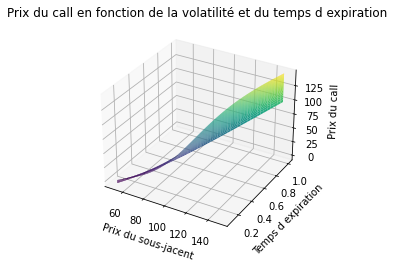

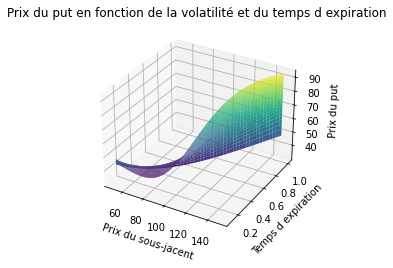

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres du modèle de Black-Scholes
T = np.linspace(0.1, 1, num=200) # Temps d'expiration des options
S = np.linspace(50,150,num=200) #Prix du sous-jacent

# Calcul des prix des calls et des puts
Z_call = np.zeros((len(T), len(S)))
Z_put = np.zeros((len(T), len(S)))
for i in range(len(S)):
    for j in range(len(T)):
        
        Z_call[j,i] = call_price(S[i],K,r,T[j],sigma)[0]
        Z_put[j,i] = put_price(S[i],K,r,T[j],sigma)[0]

# Plot des surfaces des prix des calls et des puts
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Call option price
ax.plot_surface(S, T, Z_call, cmap='viridis')
ax.set_xlabel('Prix du sous-jacent')
ax.set_ylabel('Temps d expiration')
ax.set_zlabel('Prix du call')
ax.set_title('Prix du call en fonction de la volatilité et du temps d expiration')

# Put option price
fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot_surface(S, T, Z_put, cmap='viridis')
ax2.set_xlabel('Prix du sous-jacent')
ax2.set_ylabel('Temps d expiration')
ax2.set_zlabel('Prix du put')
ax2.set_title('Prix du put en fonction de la volatilité et du temps d expiration')

plt.show()


# Pricing d'une option européenne vanille : Méthode Monte Carlo

In [35]:

# Paramètre 
S = 101.15          #prix du sous-jacent 
K = 98.01           #Prix strike : prix auquel on aura le droit d'acheter le sous-jacent
vol = 0.0991        #volatility (cf site )
r = 0.01            #risk-free rate (%)
N = 10              #Nombre de pas temporelles
M = 1000            #Nombre de simulation 
market_value = 3.86 #Prix de l'option
T = ((datetime.date(2022,3,17)-datetime.date(2022,1,17)).days+1)/365    #time in years
print(T)

0.1643835616438356


In [36]:
# Constante
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S)

sum_CT = 0 #sommes des payoff
sum_CT2 = 0 #somme des erreurs standards
# Monte Carlo Method
for i in range(M):
    lnSt = lnS
    for j in range(N):
        lnSt = lnSt + nudt + volsdt*np.random.normal() #Discretisation de l'EDS regissant le prix de l'actif
        #sous Black-Scholes, on prend le log
    
    ST = np.exp(lnSt)
    CT = max(0, ST - K)
    sum_CT += CT
    sum_CT2 += + CT*CT
# Compute Expectation and SE
C0 = np.exp(-r*T)*sum_CT/M
sigma = np.sqrt( (sum_CT2 - sum_CT*sum_CT/M)*np.exp(-2*r*T) / (M-1) )
SE = sigma/np.sqrt(M)
print("La valeur du call est  ${0} avec une erreur type de +/- {1}".format(np.round(C0,2),np.round(SE,2)))


La valeur du call est  $3.84 avec une erreur type de +/- 0.11


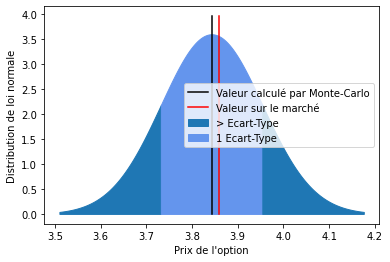

In [40]:

x1 = np.linspace(C0-3*SE, C0-1*SE, 100)
x2 = np.linspace(C0-1*SE, C0+1*SE, 100)
x3 = np.linspace(C0+1*SE, C0+3*SE, 100)
s1 = stats.norm.pdf(x1, C0, SE)
s2 = stats.norm.pdf(x2, C0, SE)
s3 = stats.norm.pdf(x3, C0, SE)
plt.fill_between(x1, s1, color='tab:blue',label='> Ecart-Type')
plt.fill_between(x2, s2, color='cornflowerblue',label='1 Ecart-Type')
plt.fill_between(x3, s3, color='tab:blue')
plt.plot([C0,C0],[0, max(s2)*1.1], 'k',
        label='Valeur calculé par Monte-Carlo')
plt.plot([market_value,market_value],[0, max(s2)*1.1], 'r',
        label='Valeur sur le marché')
plt.ylabel("Distribution de loi normale")
plt.xlabel("Prix de l'option")
plt.legend()
plt.show()